## Timestep numbering:

* t<sub>0</sub> is 'now':  It's the most recent observation.
* t<sub>1</sub> is the first forecast.
* t<sub>+f</sub> is the f<sup>th</sup> forecast timestep (where _f_ stands for forecast).
* t<sub>-h</sub> is the h<sup>th</sup> history timestep (where _h_ stands for history).

In [1]:
import numpy as np
import pandas as pd
from multiprocessing import managers, shared_memory
import enum
from concurrent import futures
import xarray as xr
import gcsfs
from typing import Dict, List, Union, Callable, Optional
import torch
from collections import namedtuple
from dataclasses import dataclass
from functools import partial
import cv2 as cv
import matplotlib.pyplot as plt
import multiprocessing
from matplotlib import animation
from IPython.display import HTML

In [2]:
import pytorch_lightning as pl
from torch import nn
import torch.nn.functional as F

In [3]:
HRV_CHANNEL = 0

In [4]:
DATE_FORECAST_ABOUT = 'DATE_FORECAST_ABOUT'
FORECAST_HORIZON = 'FORECAST_HORIZON'
HISTORICAL_SAT_IMAGES = 'HISTORICAL_SAT_IMAGES'
IMAGE = 'IMAGE'
OPTICAL_FLOW_PREDICTIONS = 'OPTICAL_FLOW_PREDICTIONS'
OPTICAL_FLOW_FIELDS = 'OPTICAL_FLOW_FIELDS'
SAT_IMAGES = 'SAT_IMAGES'
TARGET_SAT_IMAGE = 'TARGET_SAT_IMAGE'
T0 = 'T0'

In [5]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'none'

In [6]:
ZARR = 'solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/OSGB36/all_zarr_int16'

def get_sat_dataset(filename=ZARR):
    gcs = gcsfs.GCSFileSystem()
    store = gcsfs.GCSMap(root=filename, gcs=gcs)
    dataset = xr.open_zarr(store, consolidated=True)
    return dataset

In [7]:
# TODO: Rename this variable - it's a bit ambiguous what it refers to
OPT_FLOW_DTYPE = np.float32


def convert_10bpp_to_uint8(array):
    "Convert 10 bit per pixel to uint8"
    # Divide by 4 to get from a range of [0, 1023] to [0, 255].
    array = array / 4.0
    array = array.round()
    assert array.min() >= 0
    assert array.max() <= 255
    return array.astype(np.uint8)


def _compute_optical_flow(sat_data: np.ndarray, timestep: int) -> np.ndarray:
    """
    Args:
        sat_data: uint8 numpy array of shape (num_timesteps, height, width)
        timestep: The timestep to process.
        
    Returns:
        optical flow field
    """
    prev_img = sat_data[timestep]
    next_img = sat_data[timestep+1]
    return cv.calcOpticalFlowFarneback(
        prev=prev_img, next=next_img, flow=None, pyr_scale=0.5, levels=2, winsize=40, iterations=3, 
        poly_n=5, poly_sigma=0.7, flags=cv.OPTFLOW_FARNEBACK_GAUSSIAN)


def _get_opt_flow_shape(sat_data_shape):
    num_timesteps, height, width = sat_data_shape
    num_flows = num_timesteps - 1
    opt_flow_shape = (num_flows, height, width, 2)
    return opt_flow_shape


def _compute_optical_flow_worker_process(
    timestep: int, 
    sat_data_shape: tuple, 
    sat_data_shared_mem: shared_memory.SharedMemory, 
    opt_flow_shared_mem: shared_memory.SharedMemory) -> None:
    """To be run as a separate process. Gets sat data from shared memory.
    Computes optical flow for pair of images (at timesteps t and t+1).
    
    Args:
        timestep: Index into sat_data for the first image on which to compute
            optical flow.  The 2nd image used for optical flow is at timestep+1.
        sat_data_shape: Tuple of (num_timesteps, height, width)
        sat_data_shared_mem: SharedMemory object.  Note that the full array isn't copied into
            each process.  Instead, memory is shared between processes.  uint8
        opt_flow_shared_mem: SharedMemory into which this function inserts the computed optical flow field.
    """
    # Attach to existing memory block for satellite data.
    sat_data_shared_array = np.ndarray(sat_data_shape, dtype=np.uint8, buffer=sat_data_shared_mem.buf)
    
    # Attach to existing memory block for the optical flow fields.
    opt_flow_shape = _get_opt_flow_shape(sat_data_shape)
    opt_flow_shared_array = np.ndarray(opt_flow_shape, dtype=OPT_FLOW_DTYPE, buffer=opt_flow_shared_mem.buf)

    # Compute optical flow.
    flow = _compute_optical_flow(sat_data_shared_array, timestep)
    
    # Copy flow to shared memory.
    opt_flow_shared_array[timestep] = flow[:]


def compute_optical_flow(sat_data: xr.DataArray) -> xr.DataArray:
    """Compute optical flow field for each pair of consecutive images using multiple processes.

    Args:
        sat_data: Satellite data loaded from disk, 10 bits per channel.
        
    Returns:
        optical flow fields as xr.DataArray, with the 'time' dimension set to
        the time of the second of the pair of input satellite images,
        using dtype OPT_FLOW_DTYPE.
    """
    # OpenCV expects uint8 images
    sat_data_uint8 = convert_10bpp_to_uint8(sat_data)
    
    # Shape maths :)
    sat_data_shape = sat_data_uint8.shape
    opt_flow_shape = _get_opt_flow_shape(sat_data_shape)
    num_timesteps = sat_data_shape[0]
    num_flows = opt_flow_shape[0]
    
    # Create a non-shared array for the resulting optical flow fields.
    opt_flow_array = np.empty(opt_flow_shape, dtype=OPT_FLOW_DTYPE)

    # To speed up processing, we use multiple processes to compute the optical flow fields.
    # Prior to Python 3.8, we'd have to pass the sat data array and the optical flow
    # arrays using pipes or on-disk files.  That's slow.  Python 3.8 allows us to share
    # memory between processes, which is much faster.
    with managers.SharedMemoryManager() as smm:
        # Create shared array for the uint8 satellite imagery.
        sat_data_shared_mem = smm.SharedMemory(size=sat_data_uint8.nbytes)
        sat_data_shared_array = np.ndarray(sat_data_shape, dtype=np.uint8, buffer=sat_data_shared_mem.buf)
        sat_data_shared_array[:] = sat_data_uint8[:]

        # Create a shared array for the resulting optical flow fields.
        opt_flow_shared_mem = smm.SharedMemory(size=opt_flow_array.nbytes)
        opt_flow_shared_array = np.ndarray(opt_flow_shape, dtype=OPT_FLOW_DTYPE, buffer=opt_flow_shared_mem.buf)

        # Fire up a bunch of processes to compute optical flow indexed on the first
        # image of the pair of images to compute optical flow for.  ProcessPoolExecutor
        # defaults to use the number of processors on the machine.
        
        opt_flow_func = partial(
            _compute_optical_flow_worker_process, 
            sat_data_shape=sat_data_shape,
            sat_data_shared_mem=sat_data_shared_mem,
            opt_flow_shared_mem=opt_flow_shared_mem)
        with futures.ProcessPoolExecutor() as executor:
            iterator = executor.map(opt_flow_func, range(num_flows))
            
        # Need to iterate through the returned iterator to raise
        # and exceptions raised by worker processes during executor.map().
        list(iterator)

        # Copy results into non-shared array before we leave the
        # SharedMemoryManager context manager.
        opt_flow_array[:] = opt_flow_shared_array[:]

    # Wrap opt_flow_array in an xr.DataArray with appropriate dimensions.
    coords = (
        ('time', sat_data['time'][1:]),
        ('y', sat_data['y']),
        ('x', sat_data['x']),
        (OPTICAL_FLOW_FIELDS, ['x', 'y']))
    
    return xr.DataArray(opt_flow_array, coords=coords, name=OPTICAL_FLOW_FIELDS)

In [8]:
# Quick test of compute_optical_flow
#sat_data = dataset.isel(time=slice(100, 110))['stacked_eumetsat_data'][..., HRV_CHANNEL]
#sat_data[0].plot();

In [9]:
def remap_image(image: np.ndarray, flow: np.ndarray) -> np.ndarray:
    """Takes an image and warps it forwards in time according to the flow field.
    
    Args:
        image: The grayscale image to warp.
        flow: A 3D array.  The first two dimensions must be the same size as the first two
            dimensions of the image.  The third dimension represented the x and y displacement.
            
    Returns:  Warped image.  The border has values np.NaN.
    """
    # Adapted from https://github.com/opencv/opencv/issues/11068
    height, width = flow.shape[:2]
    remap = -flow.copy()
    remap[..., 0] += np.arange(width)  # map_x
    remap[..., 1] += np.arange(height)[:, np.newaxis]  # map_y
    # cv.remap docs: https://docs.opencv.org/4.5.0/da/d54/group__imgproc__transform.html#gab75ef31ce5cdfb5c44b6da5f3b908ea4
    return cv.remap(
        src=image, map1=remap, map2=None, 
        interpolation=cv.INTER_LINEAR, 
        # See BorderTypes: https://docs.opencv.org/4.5.0/d2/de8/group__core__array.html#ga209f2f4869e304c82d07739337eae7c5
        borderMode=cv.BORDER_CONSTANT,
        borderValue=np.NaN
    )


def compute_optical_flow_predictions(sat_data: xr.DataArray, flows: xr.DataArray) -> pd.DataFrame:
    """Compute predictions.

    For each source image (S), and optical flow field (F), we create a predicted image (P) like this:

    source image timestep: 0 1 2 3 4 5
                           S S S S S S
                            F F F F F
                             P P P P P
                               P P P P
                                 P P P
                                   P P
                                     P

    For n source images, we have n-1 flows, and (n-1)*n / 2 predictions.  In the illustration,
    we have 6 source images, 5 flows, and 5 * 6 / 2 = 15 predictions.

    Source image 0 and 1 make flow 0.  Source image 0 and flow 0 make
    prediction 0 (which is for source timestep 1).  That is, we used source image
    0 to predict source image 1.
    
    Returns
        pd.DataFrame with sorted index of T0 (np.datetime64), 
        and columns: 
          T0 (np.datetime64): The datetime of the satellite image used to create the forecast
          FORECAST_HORIZON (np.timedelta64[m])
          IMAGE: optical flow prediction image
    """

    num_source_timesteps, height, width = sat_data.shape
    num_flows = _get_opt_flow_shape(sat_data.shape)[0]

    # Fill a list with dicts, which then gets turned into a DataFrame
    predictions = []
    for flow_i in range(num_flows):
        max_forecast_step_for_flow = (num_flows - flow_i) + 1
        for forecast_step in range(1, max_forecast_step_for_flow):
            first_image = sat_data[flow_i]
            flow = flows[flow_i].values * forecast_step
            predicted_image = remap_image(first_image.values, flow)
            forecast_horizon_td = np.timedelta64(forecast_step * MINUTES_PER_TIMESTEP, 'm')
            predictions.append({
                T0: first_image['time'].values,
                DATE_FORECAST_ABOUT: first_image['time'].values + forecast_horizon_td,
                FORECAST_HORIZON: forecast_horizon_td,
                IMAGE: predicted_image
            })
        
    return pd.DataFrame(predictions).set_index([T0, DATE_FORECAST_ABOUT]).sort_index()

In [10]:
TIMESTEPS_PER_HOUR = 12  # One timestep every 5 minutes.
MINUTES_PER_TIMESTEP = 5
NUM_RETRIES = 5

SAT_IMAGE_MEAN = np.float32(93.23458)
SAT_IMAGE_STD = np.float32(115.34247)

DateRange = namedtuple('DateRange', ['start', 'end'])


class BatchType(enum.Enum):
    TRAINING = 0
    TESTING = 1
    

@dataclass
class SatelliteLoader:
    """Loads satellite data from disk into CPU memory.
    
    Optical flow & optical flow predictions are computed in parallel on the fly.
    
    We don't explicity set a date range for training so the code can 
    automatically make use of new training data when the dataset is updated
    with new satellite data.

    Init params:
        dataset: xarray dataset of int16 EUMETSAT satellite images.
        num_forecast_timesteps: Number of timesteps ahead to predict.  Each timestep is 5 minutes long.
        testing_date_range: Date range to exclude from training data.  
            If the testing_date_range contains more data
            than can fit into a single super batch then the chronologically late
            data will not be used in either training or testing.
        rng: Random number generator.
    """
    dataset: xr.Dataset  # The only variable that _has_ to be passed in.
    num_forecast_timesteps: int = 48

    # TODO: Accept multiple date ranges.
    testing_date_range: DateRange = DateRange(start=np.datetime64('2019-06-01'), end=np.datetime64('2019-06-14'))

    rng_seed: Optional[int] = 42 

    def __post_init__(self):
        # Select just the HRV channel.
        data_array = self.dataset['stacked_eumetsat_data'][..., HRV_CHANNEL]
        self.rng = np.random.default_rng(seed=self.rng_seed)

        # Our int16 array represents NaNs as '-1'.  Lazily replace -1s with NaNs.
        data_array = data_array.astype(np.float32).where(data_array != -1, np.NaN)
        self.data_array = data_array

        # valid_start_dates is a dict mapping TRAINING and TESTING to valid start dates.
        self.valid_start_times = self._compute_valid_start_times(data_array['time'])
        
    def _compute_valid_start_times(self, datetimes) -> Dict[BatchType, np.array]:
        """Find start times for testing and training.
        
        Returns dict {TESTING: array of dates; TRAINING: array of dates}"""

        # TODO: Use clear sky irradiance to compute good hours.
        # TODO: Only select start-times which align with the start of Zarr chunks?

        datetime_index = datetimes.to_index()
        hours = datetime_index.hour
        forecast_hours = self.num_forecast_timesteps / TIMESTEPS_PER_HOUR
        end_hour = 16 - forecast_hours
        mask = (hours > 9) & (hours < end_hour)
        masked_datetimes = datetimes[mask]

        testing_mask = (self.testing_date_range.start < masked_datetimes) &  (self.testing_date_range.end > masked_datetimes)
        return {
            BatchType.TRAINING: masked_datetimes[~testing_mask].values,
            BatchType.TESTING: masked_datetimes[testing_mask].values}

    def load_satellite_data(self, batch_type: BatchType=BatchType.TRAINING) -> xr.DataArray:
        """Randomly pick a chunk of data to load off disk.

        Args:
            batch_type: Select training or testing.
        """
        # TODO: Load several complete chunks at once to make best use of Zarr's parallel reading.
        # We'll need to modify compute_optical_flow so it doesn't attempt to compute
        # optical flow for two images which are not exactly consecutive.
        
        # TODO: Figure out how many Zarr chunks to load so that the
        # resulting data fits into a super batch.
        # Consider: For the last forecast_timesteps steps in a consecutive chunk,
        # we'll have decreasingly few ground-truth examples.

        start_times = self.valid_start_times[batch_type]
        
        for retry in range(NUM_RETRIES):
            start_time = self.rng.choice(start_times)
            end_time = start_time + np.timedelta64(self.num_forecast_timesteps * MINUTES_PER_TIMESTEP, 'm')
            sat_data = self.data_array.sel(time=slice(start_time, end_time))
            if len(sat_data) == self.num_forecast_timesteps + 1:
                # Found good data!
                break
        else:
            raise ValueError(f'Failed to find valid data after {NUM_RETRIES} retries!')
            
        return sat_data.compute()

    def load_super_batch(
        self, 
        batch_type: BatchType=BatchType.TRAINING,
        include_optical_flow=True
    ) -> Dict[str, Union[xr.DataArray, np.ndarray]]:
        """
        Returns dict with:
        OPTICAL_FLOW_FIELDS:  The optical flow fields.
        OPTICAL_FLOW_PREDICTIONS: Optical flow predictions - full geographical extent).
        SAT_IMAGES: Ground-truth satellite images - full geographical extent)
        """
        satellite_data = self.load_satellite_data(batch_type)
        super_batch = {SAT_IMAGES: satellite_data}

        if include_optical_flow:
            # TODO:  Rolling average of flow fields.
            optical_flow_fields = compute_optical_flow(satellite_data)
            
            # Normalise
            satellite_data -= SAT_IMAGE_MEAN
            satellite_data /= SAT_IMAGE_STD
            
            opt_flow_predictions = compute_optical_flow_predictions(satellite_data, optical_flow_fields)
            super_batch.update({
                OPTICAL_FLOW_FIELDS: optical_flow_fields,
                OPTICAL_FLOW_PREDICTIONS: opt_flow_predictions})
        else:
            super_batch[SAT_IMAGES] -= SAT_IMAGE_MEAN
            super_batch[SAT_IMAGES] /= SAT_IMAGE_STD
            
        return super_batch

In [11]:
%%time
def load_super_batch_without_process():
    """Useful for testing"""
    dataset = get_sat_dataset()
    sat_loader = SatelliteLoader(dataset)
    return sat_loader.load_super_batch()

# super_batch = load_super_batch_without_process()

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 10.5 µs


In [12]:
def sat_data_loader_process(queue):
    dataset = get_sat_dataset()
    sat_loader = SatelliteLoader(dataset)
    while True:
        super_batch = sat_loader.load_super_batch()
        queue.put(super_batch)

In [13]:
#process.kill()

In [14]:
queue = multiprocessing.Queue(10)
process = multiprocessing.Process(target=sat_data_loader_process, args=(queue, ))
process.start()

In [15]:
process

<Process name='Process-1' pid=6398 parent=6387 started>

In [16]:
super_batch = queue.get()

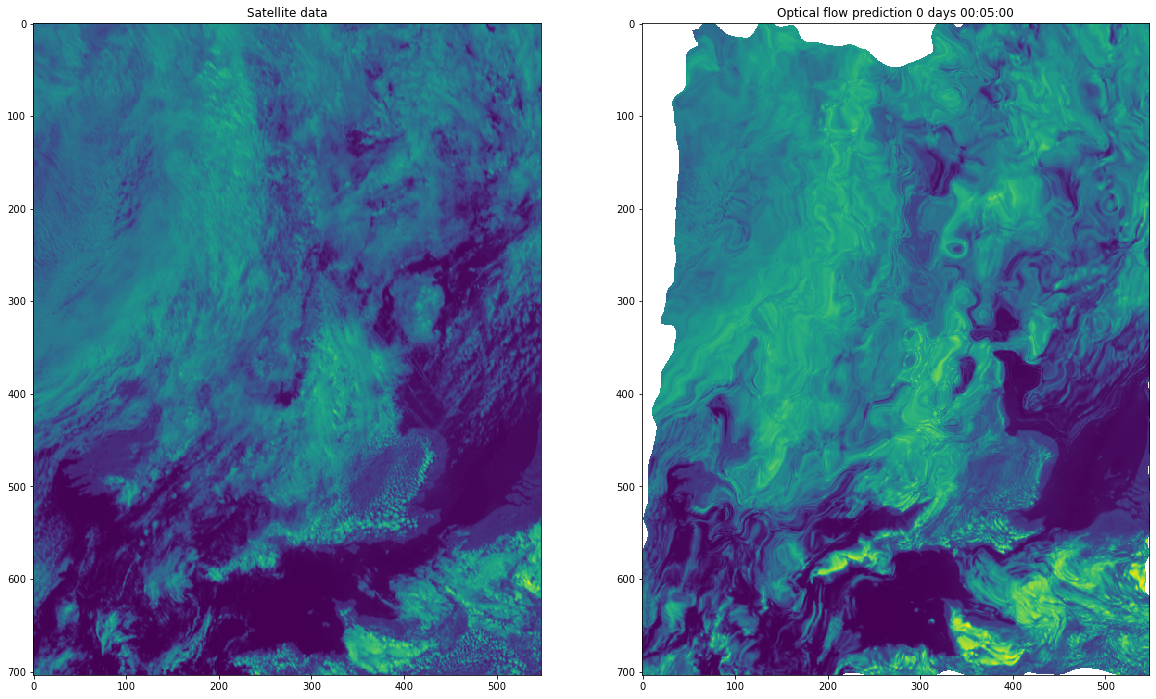

In [17]:
def plot_video(super_batch):
    fig, axes = plt.subplots(ncols=2, figsize=(20, 20))
    
    sat_data = super_batch[SAT_IMAGES]
    t0 = sat_data.time[24].values
    opt_flow_preds_from_t0 = super_batch[OPTICAL_FLOW_PREDICTIONS].loc[t0]

    i = 0
    dt = opt_flow_preds_from_t0.index[i]

    ax = axes[0]
    ax.set_title('Satellite data')
    sat_data_ax_img = ax.imshow(sat_data.loc[dt])

    ax = axes[1]
    opt_flow_pred_for_timestep = opt_flow_preds_from_t0.loc[dt]
    ax.set_title(f'Optical flow prediction {opt_flow_pred_for_timestep.FORECAST_HORIZON}')
    opt_flow_ax_img = ax.imshow(opt_flow_pred_for_timestep.IMAGE)

    def update(i):
        dt = opt_flow_preds_from_t0.index[i]
        sat_data_ax_img.set_data(sat_data.loc[dt])
        opt_flow_ax_img.set_data(opt_flow_preds_from_t0.loc[dt].IMAGE)


    anim = animation.FuncAnimation(fig, update, frames=23, interval=120)
    return HTML(anim.to_html5_video())

plot_video(super_batch)

In [18]:
from typing import Dict, Optional, Callable
import numpy as np
import torch
from dataclasses import dataclass

In [19]:
class ImageHasNansError(Exception):
    pass


def sample_squares(
    super_batch_full_geo_extent: Dict[str, np.ndarray],
    rng: np.random.Generator,
    n_pixels_per_side_large: int = 128,
    n_pixels_per_side_small: int = 64,
    large_images=(OPTICAL_FLOW_PREDICTIONS, HISTORICAL_SAT_IMAGES),  # Do OPTICAL_FLOW_PREDICTIONS first, because they're most likely to have NaNs!
    small_images=(TARGET_SAT_IMAGE,)
    ) -> Dict[str, np.ndarray]:
    """Randomly samples square crops.
    
    If any of the cropped images has NaNs then raises ImageHasNansError.
    """
    def _crop(image_names, top, bottom, left, right):
        for image_name in image_names:
            image = super_batch_full_geo_extent[image_name]
            image = image[..., top:bottom, left:right]
            if np.any(np.isnan(image)):
                raise ImageHasNansError(f'{image_name} has NaNs!')
            super_batch_full_geo_extent[image_name] = image
    
    # Calculate maximum x and y for the top left corner of the history crop.
    height, width = super_batch_full_geo_extent[large_images[0]].shape[-2:]
    large_max_x = width - n_pixels_per_side_large
    large_max_y = height - n_pixels_per_side_large
    border_between_large_and_small = (n_pixels_per_side_large - n_pixels_per_side_small) // 2
    
    # Crop large images
    large_top = rng.integers(low=0, high=large_max_y)
    large_bottom = large_top + n_pixels_per_side_large
    large_left = rng.integers(low=0, high=large_max_x)
    large_right = large_left + n_pixels_per_side_large
    _crop(large_images, large_top, large_bottom, large_left, large_right)
    
    # Crop small images
    small_top = large_top + border_between_large_and_small
    small_bottom = large_bottom - border_between_large_and_small
    small_left = large_left + border_between_large_and_small
    small_right = large_right - border_between_large_and_small
    _crop(small_images, small_top, small_bottom, small_left, small_right)

    return super_batch_full_geo_extent    

In [20]:
SECONDS_PER_TIMESTEP = MINUTES_PER_TIMESTEP * 60
FCST_HORIZON_SEQ = np.arange(1, 24, dtype=np.float32) * SECONDS_PER_TIMESTEP
FCST_HORIZON_MEAN = FCST_HORIZON_SEQ.mean()
FCST_HORIZON_STD = FCST_HORIZON_SEQ.std()

def normalise_forecast_horizon(forecast_horizon):
    """
    Args:
        forecast_horizon: int: number of seconds
    """
    forecast_horizon = np.float32(forecast_horizon)
    forecast_horizon -= FCST_HORIZON_MEAN
    forecast_horizon /= FCST_HORIZON_STD
    return forecast_horizon

In [21]:
def super_batch_to_example(
    super_batch: Dict[str, object], 
    rng: Optional[np.random.Generator] = None,
    n_historical_images: int = 4,  # number of images output in HISTORICAL_SAT_IMAGES
    history_stride: int = 3,  # timesteps to skip
    ) -> Dict[str, object]:
    """
    First, pick a random index for the start of the historical image sequence.
    
    Then pick a target image, a random horizon ahead of the t0 image.
    """
    
    # Get index of first historical image
    n_sat_images = len(super_batch[SAT_IMAGES])
    total_hist_length = n_historical_images * history_stride
    max_hist_start_idx = n_sat_images - total_hist_length - 1  # the -1 is for the prediction at least 1 timestep into the future.
    
    MAX_RETRIES = 128
    for _ in range(MAX_RETRIES):
        hist_start_idx = rng.integers(low=0, high=max_hist_start_idx)
        hist_end_idx = hist_start_idx + total_hist_length
        
        t0_idx = hist_end_idx - 1  # because history range is [hist_start_idx, hist_end_idx), and the end of the history is t0
        t0_dt = super_batch[SAT_IMAGES].time[t0_idx].values
        
        # Get all the available optical flow predictions made at t0
        opt_flow_preds_for_t0 = super_batch[OPTICAL_FLOW_PREDICTIONS].loc[t0_dt]
        
        # Pick one optical flow prediction.
        target_dt = rng.choice(opt_flow_preds_for_t0.index)
        
        # Prepare data:
        opt_flow_pred = opt_flow_preds_for_t0.loc[target_dt]
        target_sat_image = super_batch[SAT_IMAGES].loc[target_dt].values
        forecast_horizon_float = normalise_forecast_horizon(opt_flow_pred.FORECAST_HORIZON.total_seconds())
        historical_sat_images = super_batch[SAT_IMAGES].isel(time=slice(hist_start_idx, hist_end_idx, history_stride)).values

        example = {
            TARGET_SAT_IMAGE: target_sat_image,
            FORECAST_HORIZON: forecast_horizon_float,
            HISTORICAL_SAT_IMAGES: historical_sat_images,
            OPTICAL_FLOW_PREDICTIONS: opt_flow_pred.IMAGE
        }
        
        # Inner retry loop for sampling different locations from the same timesteps,
        # mostly because the optical flow predictions have NaNs at the smeared edges.
        for _ in range(MAX_RETRIES):
            try:
                example = sample_squares(example, rng=rng)
            except ImageHasNansError as e:
                pass
            else:
                return example
    raise ImageHasNansError(f'Cropped images still have NaNs, even after {MAX_RETRIES ** 2} retries!')

In [22]:
%%time
example = super_batch_to_example(super_batch, rng=np.random.default_rng())

CPU times: user 4.48 ms, sys: 0 ns, total: 4.48 ms
Wall time: 4.14 ms


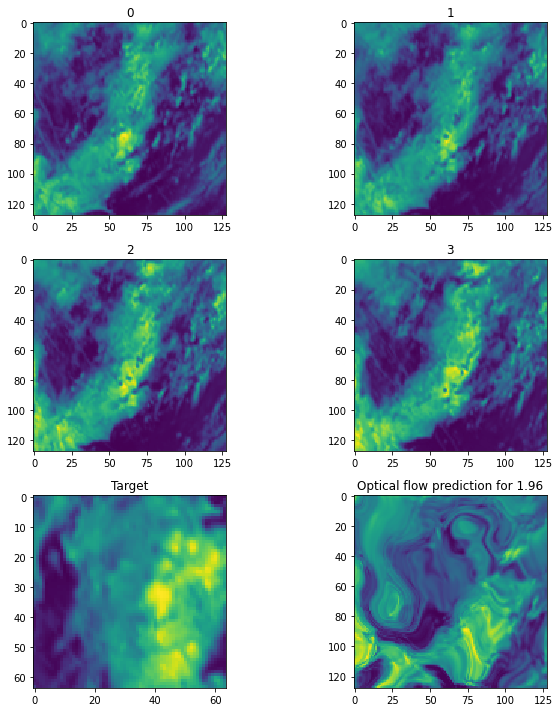

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=2)

axes_flat = np.array(axes).flatten()
for img_i, (img, ax) in enumerate(zip(example[HISTORICAL_SAT_IMAGES], axes_flat[:-2])):
    ax.imshow(img)
    ax.set_title(img_i)
    
ax = axes[2, 0]
ax.imshow(example[TARGET_SAT_IMAGE])
ax.set_title('Target')

ax = axes[2, 1]
ax.imshow(example[OPTICAL_FLOW_PREDICTIONS])
horizon = example[FORECAST_HORIZON]
ax.set_title(f'Optical flow prediction for {horizon:.2f}')
    
fig.tight_layout()

In [24]:
class ValidationDataset(torch.utils.data.Dataset):
    def __init__(self):
        dataset = get_sat_dataset()
        sat_loader = SatelliteLoader(dataset, rng_seed=42)
        self.examples = []
        rng = np.random.default_rng(seed=42)
        for super_batch_i in range(8):
            print('Loading super_batch', super_batch_i)
            super_batch = sat_loader.load_super_batch(batch_type=BatchType.TESTING)
            for _ in range(512):
                example = super_batch_to_example(super_batch, rng=rng)
                self.examples.append(example)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        return self.examples[idx]

In [25]:
%%time
val_dataset = ValidationDataset()

Loading super_batch 0
Loading super_batch 1
Loading super_batch 2
Loading super_batch 3
Loading super_batch 4
Loading super_batch 5
Loading super_batch 6
Loading super_batch 7
CPU times: user 7min 33s, sys: 27.7 s, total: 8min 1s
Wall time: 2min 3s


In [26]:
len(val_dataset)

4096

In [27]:
val_dataset[0].keys()

dict_keys(['TARGET_SAT_IMAGE', 'FORECAST_HORIZON', 'HISTORICAL_SAT_IMAGES', 'OPTICAL_FLOW_PREDICTIONS'])

In [28]:
val_dataset[0]['FORECAST_HORIZON'].dtype

dtype('float32')

In [29]:
BATCH_SIZE = 64

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    drop_last=True,
    num_workers=4
)

In [30]:
@dataclass
class InMemDataset(torch.utils.data.IterableDataset):
    sat_loader_queue: multiprocessing.Queue
    n_super_batches: int = 8  # Number of super-batches to keep in CPU memeory at any one time.
        
    # This needs to be large enough to give the dataset loader process enough time
    # to load a new super batch into RAM and pre-process it!
    n_examples_per_epoch: int = 1024 * 6
    
    def __post_init__(self):
        self.rng = np.random.default_rng(seed=42)
        self.super_batches = []
        self._super_batch_to_replace = 0
        for i in range(self.n_super_batches):
            print('Loading super_batch', i)
            self.super_batches.append(self.sat_loader_queue.get())

    def __iter__(self):
        for _ in range(self.n_examples_per_epoch):
            super_batch_i = self.rng.integers(low=0, high=self.n_super_batches, dtype=np.uint8)
            super_batch = self.super_batches[super_batch_i]
            example = super_batch_to_example(super_batch, rng=self.rng)
            yield example
            
        self._get_new_batch()
            
    def _get_new_batch(self):
        self.super_batches[self._super_batch_to_replace] = self.sat_loader_queue.get()
        self._super_batch_to_replace += 1
        if self._super_batch_to_replace >= self.n_super_batches:
            self._super_batch_to_replace = 0

In [31]:
%%time
in_mem_dataset = InMemDataset(sat_loader_queue=queue)

Loading super_batch 0
Loading super_batch 1
Loading super_batch 2
Loading super_batch 3
Loading super_batch 4
Loading super_batch 5
Loading super_batch 6
Loading super_batch 7
CPU times: user 7.53 s, sys: 29.9 s, total: 37.4 s
Wall time: 51.9 s


In [32]:
# in_mem_dataset.n_examples_per_epoch = 1024 * 4

In [33]:
dataloader = torch.utils.data.DataLoader(
    in_mem_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    drop_last=True,
    #num_workers=8
)

In [34]:
%%time
for d in dataloader:
    break

CPU times: user 3.56 s, sys: 1.12 s, total: 4.68 s
Wall time: 3.2 s


In [35]:
d.keys()

dict_keys(['TARGET_SAT_IMAGE', 'FORECAST_HORIZON', 'HISTORICAL_SAT_IMAGES', 'OPTICAL_FLOW_PREDICTIONS'])

In [36]:
batch_i = 3
d[FORECAST_HORIZON][batch_i]

tensor(-1.3568)

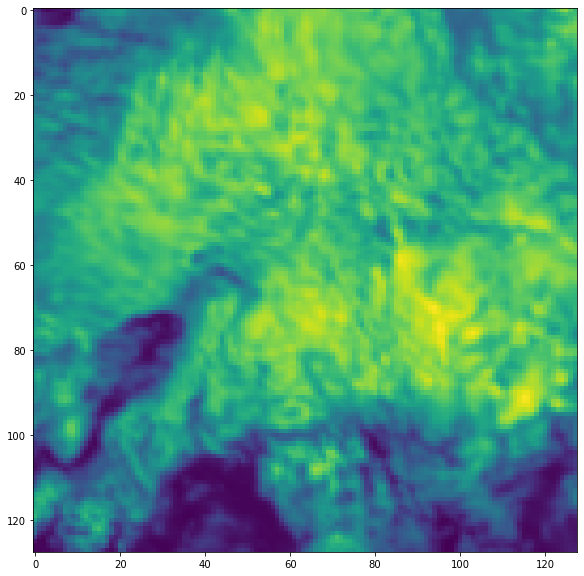

In [37]:
plt.imshow(d[OPTICAL_FLOW_PREDICTIONS][batch_i])

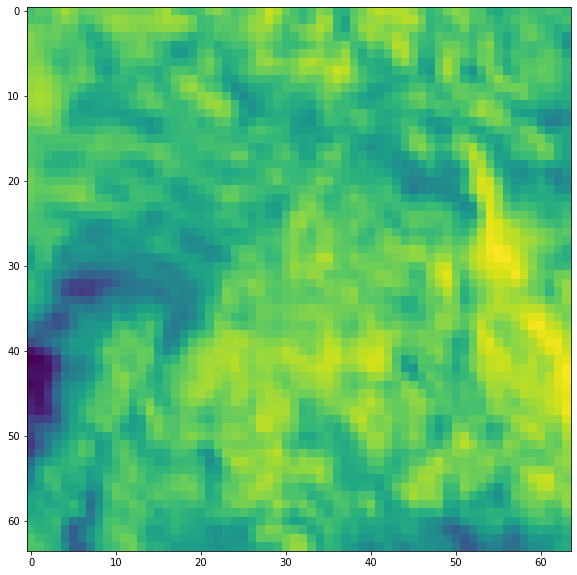

In [38]:
plt.imshow(d[TARGET_SAT_IMAGE][batch_i]);

In [76]:
CHANNELS = 32
KERNEL = 3
STRIDE = 2

class LitAutoEncoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.conv = nn.Sequential(
            # Encoder
            nn.Conv2d(in_channels=6, out_channels=CHANNELS//2, kernel_size=KERNEL, stride=STRIDE),
            nn.ReLU(),
            nn.Conv2d(in_channels=CHANNELS//2, out_channels=CHANNELS, kernel_size=KERNEL, stride=STRIDE),
            nn.ReLU(),
            nn.Conv2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=KERNEL, stride=STRIDE),
            nn.ReLU(),
            nn.Conv2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=KERNEL, stride=STRIDE),
            nn.ReLU(),
            
            # Decoder
            nn.ConvTranspose2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=KERNEL, stride=STRIDE),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=CHANNELS, out_channels=CHANNELS//2, kernel_size=KERNEL, stride=STRIDE),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=CHANNELS//2, out_channels=1, kernel_size=KERNEL, stride=STRIDE),
        )

    def forward(self, x):
        images = torch.cat(
            (
                x[HISTORICAL_SAT_IMAGES], 
                x[OPTICAL_FLOW_PREDICTIONS].unsqueeze(1)
            ),
            dim=1)
        
        # Append forecast horizon as an extra channel
        batch_size, n_channels, height, width = images.shape
        new_shape_for_forecast_horizon = (batch_size, 1, height, width)
        forecast_horizon = x[FORECAST_HORIZON].view(-1, 1, 1, 1).expand(*new_shape_for_forecast_horizon)
        images = torch.cat((images, forecast_horizon), dim=1)  # cat on channel dimension
        
        return self.conv(images)
    
    def _training_or_validation_step(self, batch, is_train_step):
        y_hat = self(batch)
        y_hat = y_hat.squeeze()
        y = batch[TARGET_SAT_IMAGE]
        y = y[..., :-1, :-1]  # Due to the CNN stride, the output image is 63 x 63
        loss = F.mse_loss(y_hat, y)
        tag = "Loss/Train" if is_train_step else "Loss/Validation"
        self.log_dict({tag: loss}, on_step=is_train_step, on_epoch=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._training_or_validation_step(batch, is_train_step=True)
    
    def validation_step(self, batch, batch_idx):
        return self._training_or_validation_step(batch, is_train_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        return optimizer

In [77]:
model = LitAutoEncoder()

In [78]:
#d[HISTORICAL_SAT_IMAGES] = d[HISTORICAL_SAT_IMAGES].cpu()

In [79]:
#model.conv(d[HISTORICAL_SAT_IMAGES][:, :2]).shape

In [80]:
model(d).shape

torch.Size([64, 1, 63, 63])

In [81]:
logger = pl.loggers.TensorBoardLogger(save_dir='tensorboard_logs')

In [82]:
trainer = pl.Trainer(gpus=1, max_epochs=400, logger=logger, terminate_on_nan=True, check_val_every_n_epoch=4)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [83]:
# trainer.check_val_every_n_epoch=1

In [84]:
# trainer.max_epochs = 400

In [ ]:
%%time
trainer.fit(model, train_dataloader=dataloader, val_dataloaders=val_dataloader)


  | Name | Type       | Params
------------------------------------
0 | conv | Sequential | 38.0 K
------------------------------------
38.0 K    Trainable params
0         Non-trainable params
38.0 K    Total params


Epoch 0: : 0it [00:00, ?it/s]                                         

/home/jack/miniconda3/envs/predict_pv_yield/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0: : 64it [00:16,  3.77it/s, loss=2.32, v_num=73]
Validating: 0it [00:00, ?it/s]
Epoch 0: : 66it [00:18,  3.64it/s, loss=2.32, v_num=73]it]
Epoch 0: : 77it [00:18,  4.22it/s, loss=2.32, v_num=73]t/s]
Epoch 0: : 88it [00:18,  4.79it/s, loss=2.32, v_num=73]t/s]
Epoch 0: : 99it [00:18,  5.35it/s, loss=2.32, v_num=73]t/s]
Validating:  58%|█████▊    | 37/64 [00:01<00:07,  3.55it/s]
Epoch 0: : 110it [00:18,  5.89it/s, loss=2.32, v_num=73]/s]
Epoch 0: : 121it [00:18,  6.43it/s, loss=2.32, v_num=73]/s]
Epoch 0: : 129it [00:19,  6.70it/s, loss=2.32, v_num=73]/s]
Epoch 1: : 64it [00:19,  3.27it/s, loss=1.06, v_num=73]    
Validating: 0it [00:00, ?it/s]
Epoch 1: : 66it [00:20,  3.19it/s, loss=1.06, v_num=73]it]
Epoch 1: : 77it [00:20,  3.70it/s, loss=1.06, v_num=73]t/s]
Epoch 1: : 88it [00:20,  4.21it/s, loss=1.06, v_num=73]t/s]
Epoch 1: : 99it [00:21,  4.70it/s, loss=1.06, v_num=73]t/s]
Epoch 1: : 110it [00:21,  5.19it/s, loss=1.06, v_num=73]/s]
Validating:  72%|███████▏  | 46/64 [00:01<00

In [60]:
output = model.cpu()(d)

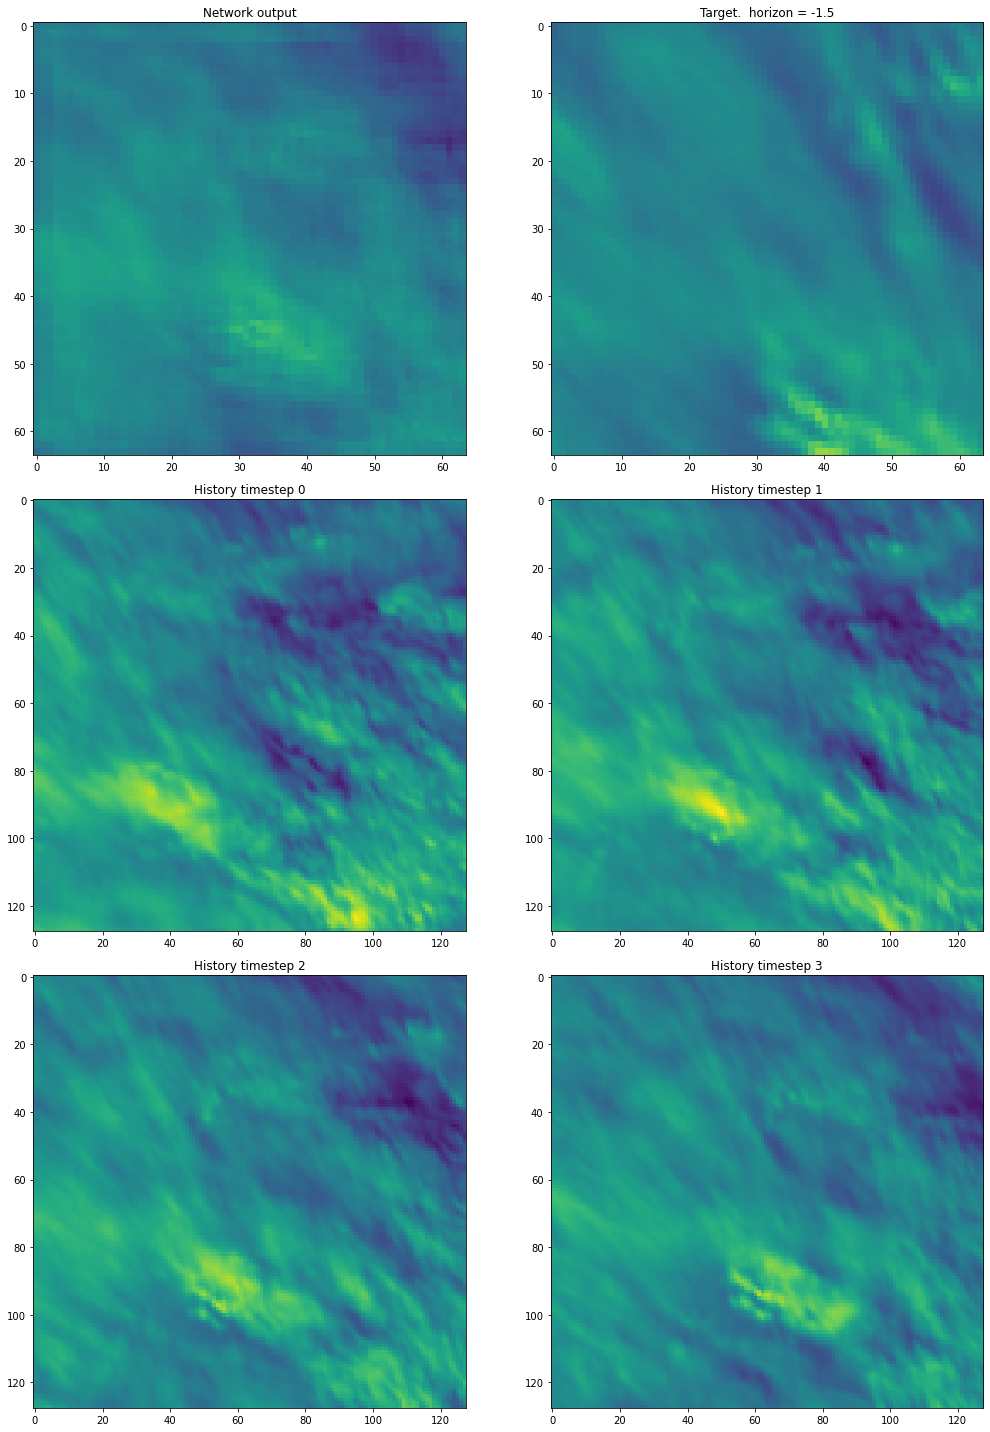

In [76]:
example_i = 14
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15, 20))

hist_sat_images_for_example = d[HISTORICAL_SAT_IMAGES][example_i].cpu().detach().numpy()
imshow_args = dict(
    vmin=hist_sat_images_for_example.min(), 
    vmax=hist_sat_images_for_example.max())

ax = axes[0, 0]
ax.set_title('Network output')
ax.imshow(output[example_i, 0, 0].cpu().detach().numpy(), **imshow_args)

ax = axes[0, 1]
ax.set_title(f'Target.  horizon = {d[FORECAST_HORIZON][example_i]:.1f}')
ax.imshow(d[TARGET_SAT_IMAGE][example_i].cpu(), **imshow_args)

for hist_img_i in range(N_HIST_IMAGES):
    row = (hist_img_i // 2) + 1
    col = hist_img_i % 2
    ax = axes[row, col]
    ax.set_title(f'History timestep {hist_img_i}')
    ax.imshow(hist_sat_images_for_example[hist_img_i], **imshow_args)

fig.tight_layout()